# Experiments with real data (Obesity)

https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition

## Requirements

In [65]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from db_robust_clust.plots import clustering_MDS_plot_multiple_methods
from db_robust_clust.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_heart_disease_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..',  '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_obesity import get_config as get_config_exp_1_obesity
from config_experiment_3_obesity import get_config as get_config_exp_3_obesity
from config_experiment_4_obesity import get_config as get_config_exp_4_obesity

---

In [66]:
import polars as pl
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
data_info = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = pl.from_pandas(data_info.data.features)
y = pl.from_pandas(data_info.data.targets)

df = pl.concat([X,y], how='horizontal')

In [67]:
df = df.drop('NObeyesdad')

In [68]:
df = df.with_columns((pl.col('Weight') / (pl.col('Height') ** 2)).alias('IMC'))

df = df.with_columns(pl.col('IMC').cut(
    breaks=[18.5, 25, 30, 35, 40],
    labels=['<18.5', # Infrapeso
            '[18.5,25)', # Normopeso
            '[25,30)', # Sobrepeso
            '[30,35)', # Obseidad tipo I
            '[35,40)', # Obseidad tipo II
            '>=40'# Obseidad tipo III
        ],
    left_closed=True
).alias('IMC_scale'))

df = df.drop(['IMC'])

In [69]:
quant_cols = ['Age', 'Height', 'Weight']
quant_to_cat = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
ordinal_cols = ['CAEC', 'CALC', 'IMC_scale'] + quant_to_cat
cat_cols = [col for col in df.columns if df[col].dtype in [pl.String, pl.Categorical]] + quant_to_cat
nominal_cols = [col for col in cat_cols if col not in ordinal_cols]

In [70]:
df = df.with_columns(pl.col('FCVC').cut(
    breaks=[1.5, 2.5],
    labels=['<1.5', '[1.5,2.5)', '>=2.5'],
    left_closed=True
))

df = df.with_columns(pl.col('NCP').cut(
    breaks=[2, 3],
    labels=['<=2', '(2,3]', '>3'],
    left_closed=False
))

df = df.with_columns(pl.col('CH2O').cut(
    breaks=[1.5, 2.5],
    labels=['<1.5', '[1.5,2.5)', '>=2.5'],
    left_closed=True
))

df = df.with_columns(pl.col('FAF').cut(
    breaks=[0.5, 1.5, 2.5],
    labels=['<0.5', '[0.5,1.5)', '[1.5,2.5)', '>=2.5'],
    left_closed=True
))

df = df.with_columns(pl.col('TUE').cut(
    breaks=[0.5, 1.5],
    labels=['<0.5', '[0.5,1.5)', '>=1.5'],
    left_closed=True
))

In [71]:
encoding = {}

encoding['CAEC'] = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

encoding['CALC'] = {
    'no': 0,
    'Sometimes': 1,
    'Frequently': 2,
    'Always': 3
}

encoding['FCVC'] = {
    '<1.5': 0,
    '[1.5,2.5)': 1,
    '>=2.5': 2         
}

encoding['NCP'] = {
    '<=2': 0,
    '(2,3]': 1,
    '>3': 2         
}

encoding['CH2O'] = {
    '<1.5': 0,
    '[1.5,2.5)': 1,
    '>=2.5': 2         
}

encoding['FAF'] = {
    '<0.5': 0,
    '[0.5,1.5)': 1,
    '[1.5,2.5)': 2,
    '>=2.5': 3         
}

encoding['TUE'] = {
    '<0.5': 0,
    '[0.5,1.5)': 1,
    '>=1.5': 2         
}

encoding['IMC_scale'] = {
    '<18.5': 0, # Infrapeso
    '[18.5,25)': 0, # Normopeso
    '[25,30)': 0, # Sobrepeso
    '[30,35)': 1, # Obseidad tipo I
    '[35,40)': 1, # Obseidad tipo II
    '>=40': 1  # Obesidad tipo III       
}

In [72]:
for col in nominal_cols:  
    print(col)      
    unique_values_sorted = sorted(df[col].unique().to_list())
    new_values = list(range(0, len(unique_values_sorted)))
    encoding[col] = dict(zip(unique_values_sorted, new_values))

Gender
family_history_with_overweight
FAVC
SMOKE
SCC
MTRANS


In [73]:
for col in cat_cols: 
    print(col)
    df = df.with_columns(pl.col(col).replace_strict(encoding[col]).alias(col))

Gender
family_history_with_overweight
FAVC
CAEC
SMOKE
SCC
CALC
MTRANS
IMC_scale
FCVC
NCP
CH2O
FAF
TUE


In [74]:
encoding

{'CAEC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
 'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
 'FCVC': {'<1.5': 0, '[1.5,2.5)': 1, '>=2.5': 2},
 'NCP': {'<=2': 0, '(2,3]': 1, '>3': 2},
 'CH2O': {'<1.5': 0, '[1.5,2.5)': 1, '>=2.5': 2},
 'FAF': {'<0.5': 0, '[0.5,1.5)': 1, '[1.5,2.5)': 2, '>=2.5': 3},
 'TUE': {'<0.5': 0, '[0.5,1.5)': 1, '>=1.5': 2},
 'IMC_scale': {'<18.5': 0,
  '[18.5,25)': 0,
  '[25,30)': 0,
  '[30,35)': 1,
  '[35,40)': 1,
  '>=40': 1},
 'Gender': {'Female': 0, 'Male': 1},
 'family_history_with_overweight': {'no': 0, 'yes': 1},
 'FAVC': {'no': 0, 'yes': 1},
 'SMOKE': {'no': 0, 'yes': 1},
 'SCC': {'no': 0, 'yes': 1},
 'MTRANS': {'Automobile': 0,
  'Bike': 1,
  'Motorbike': 2,
  'Public_Transportation': 3,
  'Walking': 4}}

In [75]:
response = 'IMC_scale'
predictors = [col for col in df.columns if col != response]
y = df[response]
X = df[predictors]

In [76]:
cat_predictors = [col for col in cat_cols if col != response]
binary_predictors = [col for col in cat_predictors if len(X[col].unique()) == 2]
multiclass_predictors = [col for col in cat_predictors if col not in binary_predictors]
quant_predictors = [col for col in X.columns if col not in cat_predictors]

p1 = len(quant_predictors)
p2 = len(binary_predictors)
p3 = len(multiclass_predictors)

X = X[quant_predictors + binary_predictors + multiclass_predictors]

In [77]:
X

Age,Height,Weight,Gender,family_history_with_overweight,FAVC,SMOKE,SCC,CAEC,CALC,MTRANS,FCVC,NCP,CH2O,FAF,TUE
f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
21.0,1.62,64.0,0,1,0,0,0,1,0,3,1,1,1,0,1
21.0,1.52,56.0,0,1,0,1,1,1,1,3,2,1,2,3,0
23.0,1.8,77.0,1,1,0,0,0,1,2,3,1,1,1,2,1
27.0,1.8,87.0,1,0,0,0,0,1,2,4,2,1,1,2,0
22.0,1.78,89.8,1,0,0,0,0,1,1,3,1,0,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
20.976842,1.71073,131.408528,0,1,1,0,0,1,1,3,2,1,1,2,1
21.982942,1.748584,133.742943,0,1,1,0,0,1,1,3,2,1,1,1,1
22.524036,1.752206,133.689352,0,1,1,0,0,1,1,3,2,1,1,1,1


In [78]:
y

IMC_scale
i64
0
0
0
0
0
…
1
1
1


In [15]:
quant_predictors

['Age', 'Height', 'Weight']

In [16]:
binary_predictors

['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

In [17]:
multiclass_predictors

['CAEC', 'CALC', 'MTRANS', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [79]:
output = {
    'df': df, 
    'X': X, 
    'y': y, 
    'p1': p1, 
    'p2': p2, 
    'p3': p3,
    'encoding': encoding,
    'quant_predictors': quant_predictors,
    'binary_predictors': binary_predictors,
    'multiclass_predictors': multiclass_predictors
}

In [80]:
n_clusters = len(y.unique())
n_clusters

2

In [82]:
y.unique()

IMC_scale
i64
0
1


In [81]:
y.unique_counts() / len(y)

IMC_scale
f64
0.538607
0.461393


In [83]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""Age""",10.87035,35.07779,168,1943,0.079583,0.920417
"""Height""",1.42226,1.976233,1,2110,0.000474,0.999526
"""Weight""",2.582867,170.422539,1,2110,0.000474,0.999526


In [84]:
outliers_df['prop_outliers'].mean()

0.026843518079898935

In [85]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,Age,Height,Weight
Age,1.000000,-0.025958,0.202560
Height,-0.025958,1.000000,0.463136
Weight,0.202560,0.463136,1.000000


In [86]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.0
Proportion of pair-wise correlations in [0.30, 0.60]:  0.33
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.67


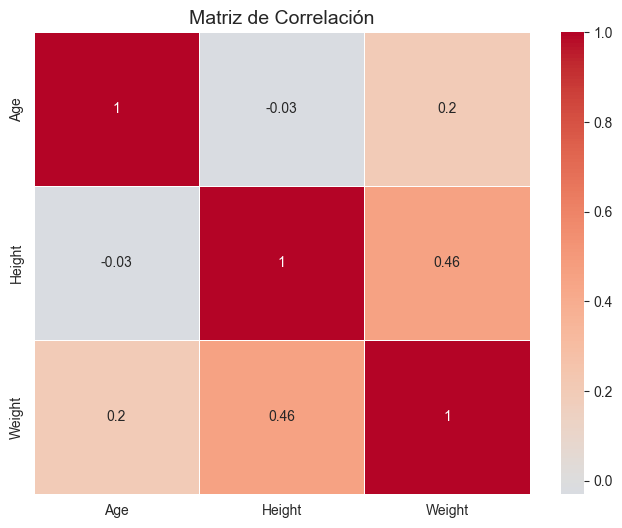

In [87]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()


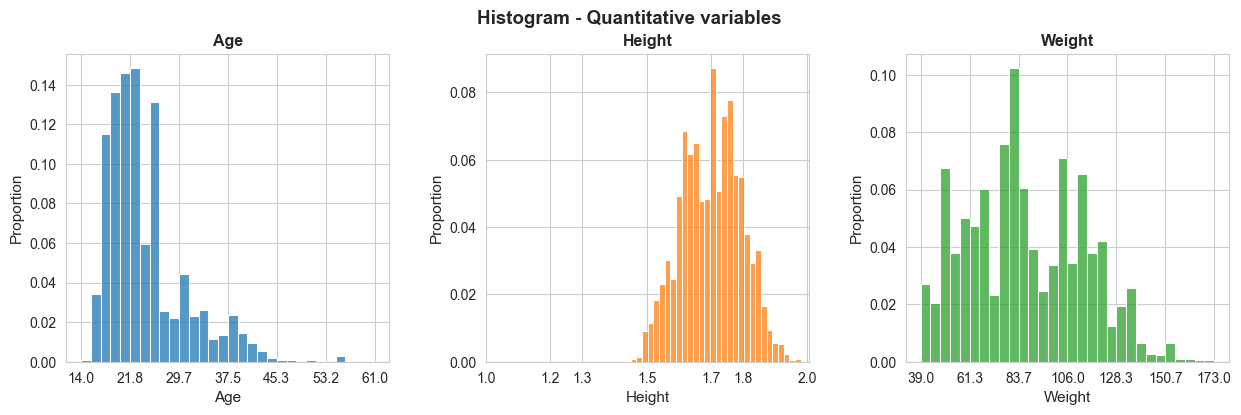

In [27]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,4), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.99,
                 style='whitegrid', hspace=0.85, wspace=0.3, n_round_xticks=1)

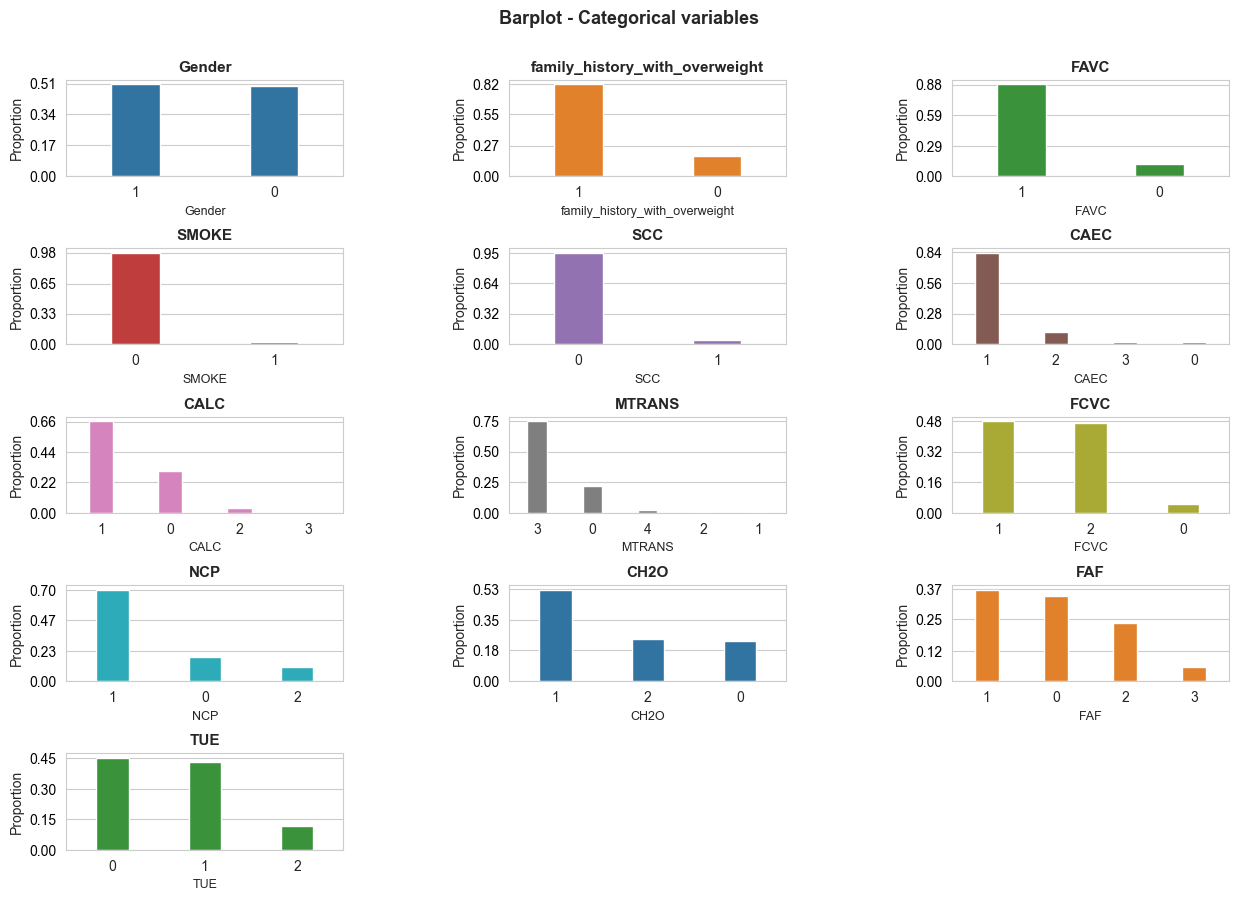

In [28]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,10), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.6, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

---


## Experiment 1


In [29]:
run_experiment_1 = True

In [30]:
if run_experiment_1: 
        
    n_realizations = 10
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'obesity')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_obesity()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [31]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 250 realizations: 41 mins

chunks:   0%|          | 0/2 [00:00<?, ?chunks/s]

random_state_chunk: [857, 4385, 1428, 6672, 4367]
random_state: 857
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 4385
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 1428
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y

chunks:  50%|█████     | 1/2 [00:53<00:53, 53.96s/chunks]

len y_pred: 4
random_state_chunk: [1764, 625, 6211, 8785, 9213]
random_state: 1764
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 625
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_size: 0.4
len y_pred: 4
frac_sample_size: 0.5
len y_pred: 4
frac_sample_size: 0.6
len y_pred: 4
frac_sample_size: 0.7
len y_pred: 4
frac_sample_size: 0.8
len y_pred: 4
frac_sample_size: 0.9
len y_pred: 4
random_state: 6211
frac_sample_size: 0.05
len y_pred: 4
frac_sample_size: 0.1
len y_pred: 4
frac_sample_size: 0.2
len y_pred: 4
frac_sample_size: 0.3
len y_pred: 4
frac_sample_s

chunks: 100%|██████████| 2/2 [01:48<00:00, 54.44s/chunks]

len y_pred: 4


In [32]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_1', 'obesity')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_obesity_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [33]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_obesity_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'obesity')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [34]:
experiment_1_config = get_config_exp_1_obesity()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [35]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

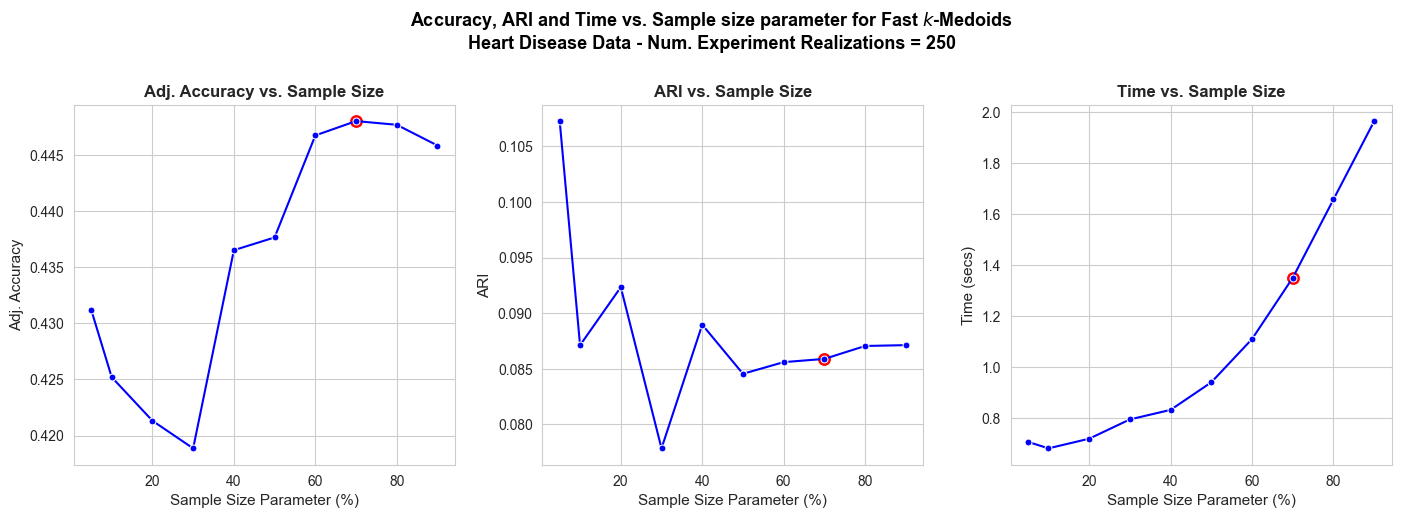

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 250', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_obesity_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [40]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.05,0.705283,0.431170,0.107263
0.10,0.679886,0.425201,0.087120
0.20,0.717765,0.421317,0.092334
0.30,0.793500,0.418854,0.077852
0.40,0.830956,0.436523,0.088966
0.50,0.939258,0.437660,0.084553
0.60,1.109161,0.446755,0.085600
0.70,1.349737,0.448034,0.085891
0.80,1.657505,0.447703,0.087053


In [41]:
print(best_frac_sample_size)

0.7



## Experiment 3


In [29]:
run_experiment_3 = True

In [30]:
if run_experiment_3: 

    n_realizations = 10
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_3', 'obesity')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_obesity()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [31]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score #balanced_accuracy_score 
                                                )

        # Save results
        results_filename = f'results_exp_3_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 10 realizations: 50 mins

chunks:   0%|          | 0/4 [00:00<?, ?chunks/s]

random_state_chunk: [857, 4385, 1428]
random_state: 857
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


random_state: 4385
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.94it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.76it/s]


random_state: 1428
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.95it/s]


frac_sample_size: 0.8


chunks:  25%|██▌       | 1/4 [02:55<08:46, 175.65s/chunks]

random_state_chunk: [6672, 4367, 1764]
random_state: 6672
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.22it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.77it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


random_state: 4367
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  4.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


random_state: 1764
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.70it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.99it/s]


frac_sample_size: 0.8


chunks:  50%|█████     | 2/4 [05:56<05:57, 178.53s/chunks]

random_state_chunk: [625, 6211, 8785]
random_state: 625
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


random_state: 6211
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]


random_state: 8785
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


frac_sample_size: 0.8


chunks:  75%|███████▌  | 3/4 [08:53<02:58, 178.03s/chunks]

random_state_chunk: [9213]
random_state: 9213
n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:03<00:00,  3.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


n_splits: 15
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]


n_splits: 20
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 20/20 [00:05<00:00,  3.61it/s]


frac_sample_size: 0.8


chunks: 100%|██████████| 4/4 [09:57<00:00, 149.49s/chunks]


In [32]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_obesity_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [33]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_obesity_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'obesity')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [34]:
config_exp_3 = get_config_exp_3_obesity()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

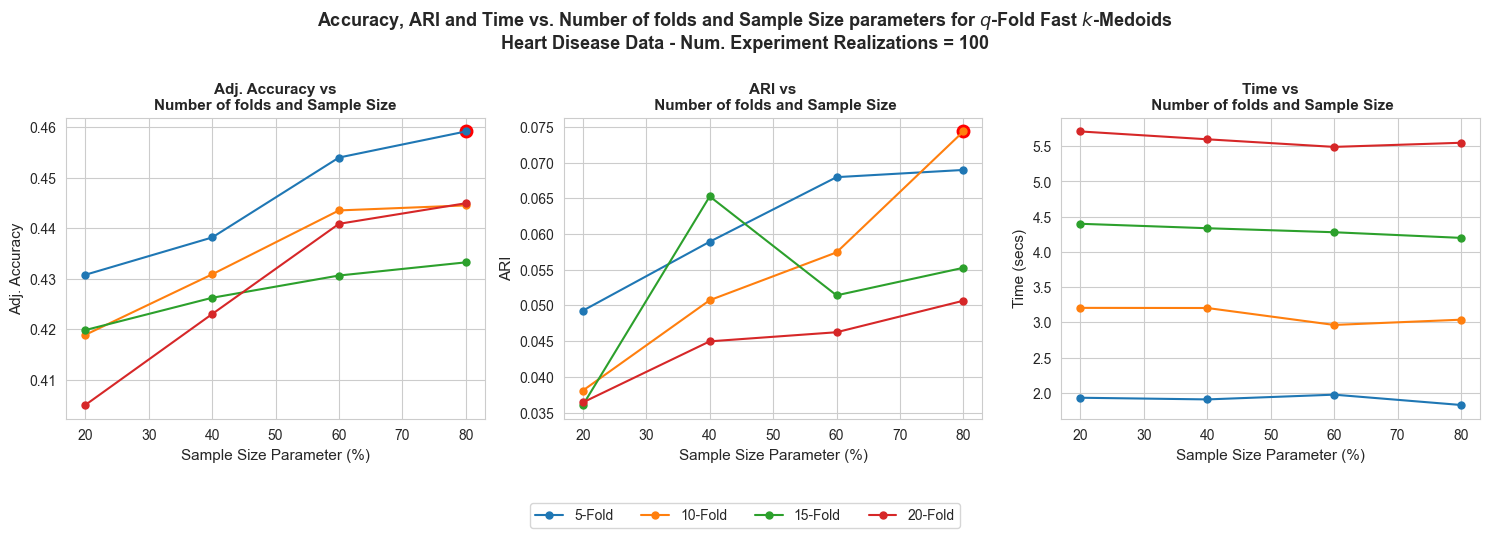

In [35]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_obesity_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [36]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,5,0.2,0.430744,0.049272,1.929785
1,5,0.4,0.438134,0.058921,1.906130
2,5,0.6,0.453955,0.067962,1.973538
3,5,0.8,0.459119,0.068970,1.826919
4,10,0.2,0.418854,0.038087,3.205787
5,10,0.4,0.430838,0.050735,3.203890
6,10,0.6,0.443486,0.057430,2.963503
7,10,0.8,0.444481,0.074360,3.038081
8,15,0.2,0.419801,0.036063,4.399605
9,15,0.4,0.426196,0.065270,4.336509


In [37]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 0.237 
 best_n_splits 5.0 
 best_frac_sample_size 0.8



## Experiment 4

In [88]:
config_exp_4 = get_config_exp_4_obesity()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis', 'euclidean', 'canberra', 'minkowski']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 10
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:


    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            label_model_name = f'{d1}_{r}-{d2}-{d3}'
        else:
            r = None
            label_model_name = f'{d1}-{d2}-{d3}'
            
        models[random_state][f'FastKmedoidsGGower-{label_model_name}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{label_model_name}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                q=1,
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [89]:
run_experiment_4 = True

In [90]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'obesity')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [91]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=accuracy_score # balanced_accuracy_score 
                )

        # Save results
        results_filename = f'results_exp_4_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 5 realizations: 20 mins

chunks:   0%|          | 0/4 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [857, 4385, 1428]
random_state: 857
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.60it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.57it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s]


len y_pred: 2
random_state: 4385
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


len y_pred: 2
random_state: 1428
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.38it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.15it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  25%|██▌       | 1/4 [01:08<03:24, 68.01s/chunks]

len y_pred: 2
chunk_id 1
random_state_chunk: [6672, 4367, 1764]
random_state: 6672
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.44it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.14it/s]
c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:297: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


len y_pred: 2
random_state: 4367
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.46it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  5.96it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.50it/s]


len y_pred: 2
random_state: 1764
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.67it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  50%|█████     | 2/4 [02:16<02:16, 68.50s/chunks]

len y_pred: 2
chunk_id 2
random_state_chunk: [625, 6211, 8785]
random_state: 625
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.36it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


len y_pred: 2
random_state: 6211
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.00it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.03it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  7.62it/s]


len y_pred: 2
random_state: 8785
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.01it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.41it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.31it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.91it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks:  75%|███████▌  | 3/4 [03:26<01:09, 69.11s/chunks]

len y_pred: 2
chunk_id 3
random_state_chunk: [9213]
random_state: 9213
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.90it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


len y_pred: 2
FastKmedoidsGGower-euclidean-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-euclidean-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.58it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


len y_pred: 2
FastKmedoidsGGower-canberra-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-canberra-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


len y_pred: 2
FastKmedoidsGGower-minkowski-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-minkowski-sokal-hamming


chunks: 100%|██████████| 4/4 [03:49<00:00, 57.38s/chunks]

len y_pred: 2


In [92]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'obesity')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_obesity_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_obesity_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [93]:
# Open merged/joined results 

results_filename = f'results_exp_4_obesity_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'obesity')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [94]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [95]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

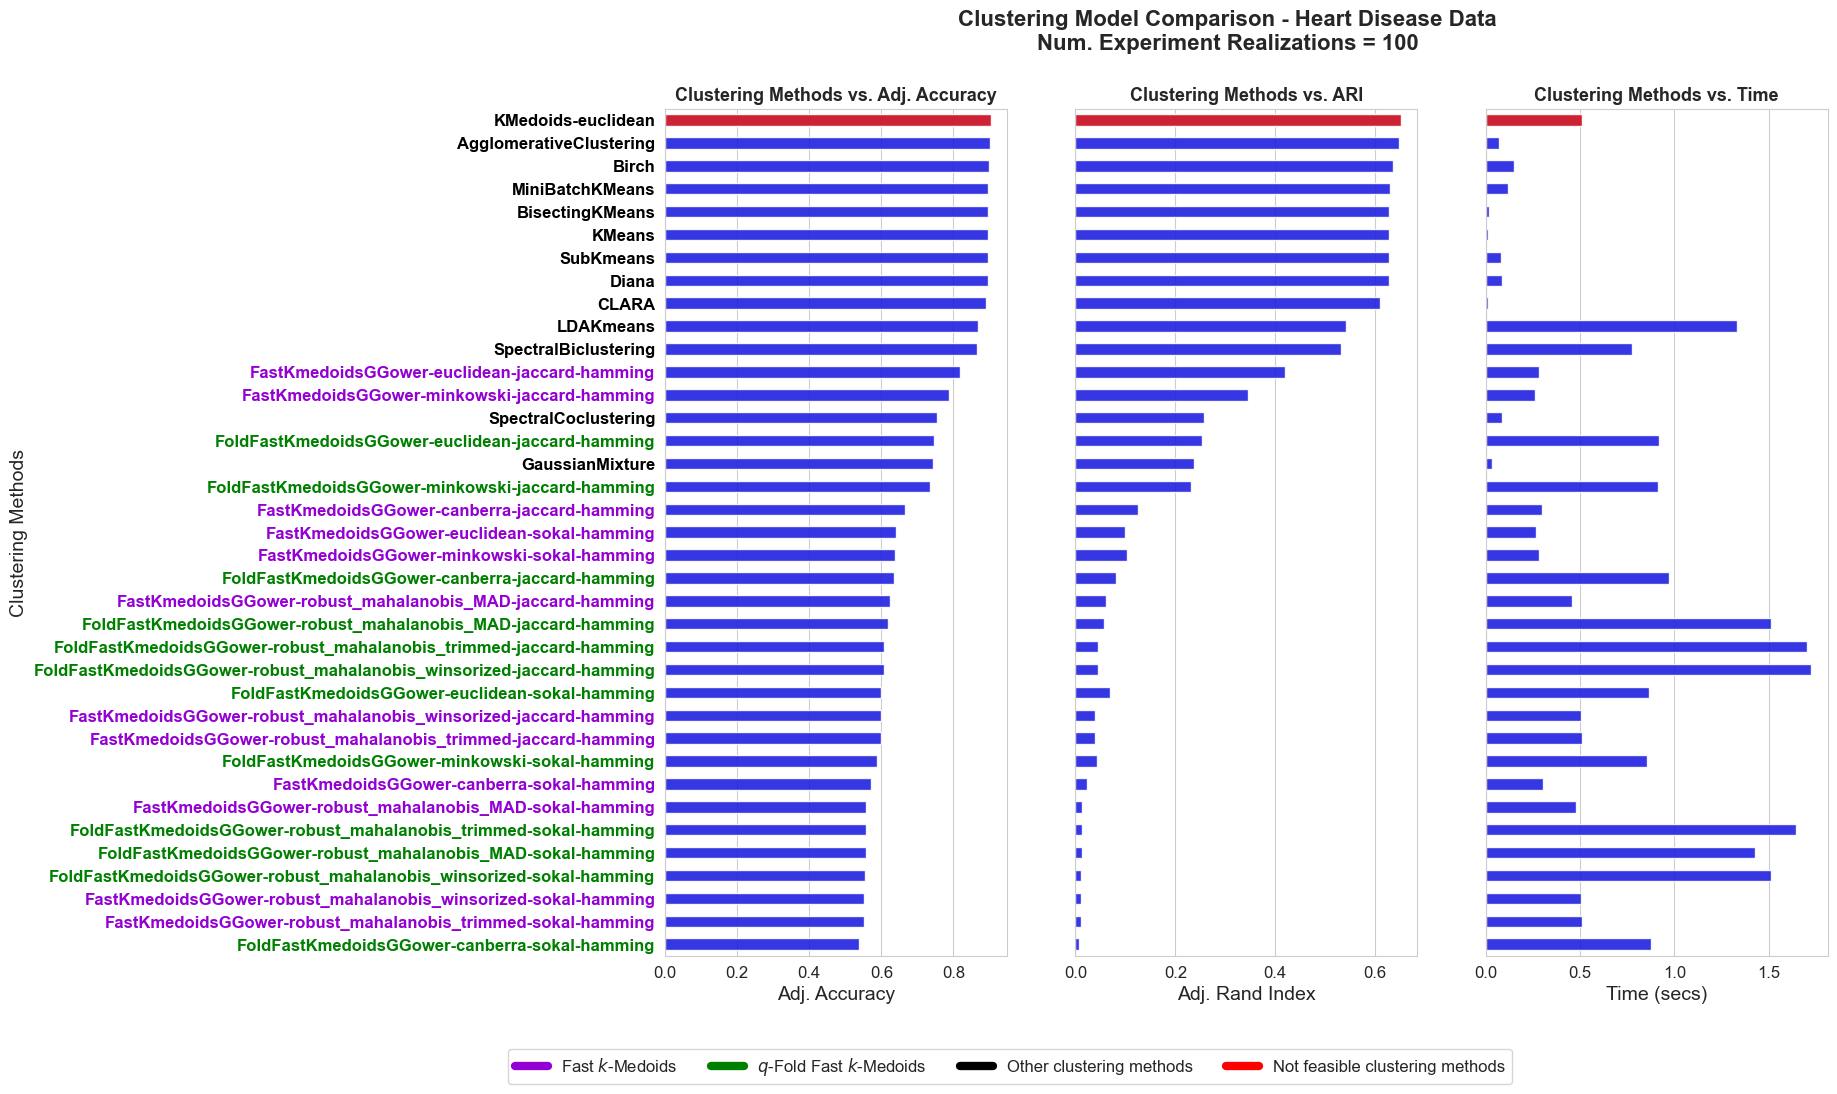

In [121]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Heart Disease Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_obesity_disease_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [102]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [103]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
KMedoids-euclidean,0.509553,0.903837,0.652111
AgglomerativeClustering,0.069662,0.902416,0.647489
Birch,0.150808,0.898626,0.635330
MiniBatchKMeans,0.119954,0.896684,0.629196
BisectingKMeans,0.015241,0.896258,0.627808
KMeans,0.010408,0.896258,0.627808
SubKmeans,0.081746,0.896258,0.627808
Diana,0.087078,0.896258,0.627816
CLARA,0.013122,0.890147,0.609024


In [118]:
random_state_mds = 857

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=0.4, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

c:\Users\fscielzo\Documents\PhD\paper-2\paper-code\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [119]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'GaussianMixture']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

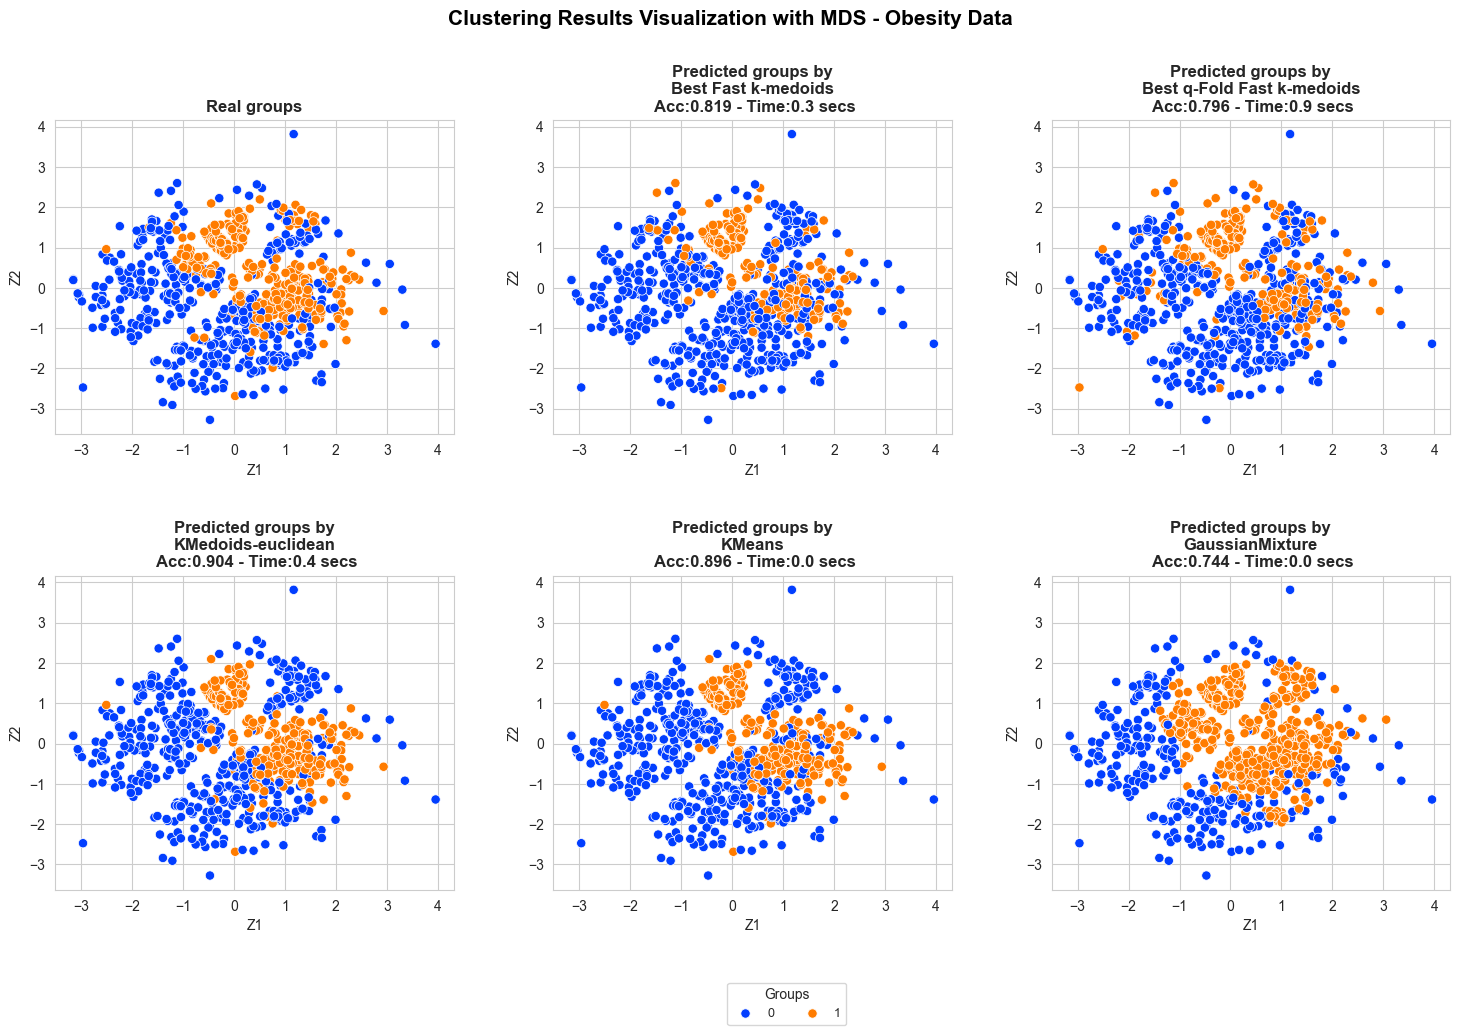

In [120]:
plot_filename = f'mds_plot_exp_4_breast_cancer_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'breast_cancer')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Obesity Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)